# Bismayan's recoding of Rossmann POC

## Initial Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import pandas as pd
from isoweek import Week
import random,pickle
import numpy as np
import datetime
from pandas_summary import DataFrameSummary
import feather
from functools import partial

from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Embedding,Concatenate,BatchNormalization
from tensorflow.keras.models import Model

from tensorflow.keras.optimizers import Adam, SGD,RMSprop

%matplotlib inline


## Setting Paths

In [2]:
data_path="/media/2tb_hdd/deeplearning_data/rossmann_data/"
file_save_path="/media/2tb_hdd/deeplearning_data/rossmann_data/"
weights_save_path="/media/2tb_hdd/deeplearning_data/rossmann_data/saved_weights/"
submissions_path="./submissions/"
#data_path="/mnt/disks/data_disk/rossmann_data/"
#file_save_path="/mnt/disks/data_disk/rossmann_data/bismayan_files/"

## Data Prep Section (Skip after first iteration)

### Getting the Main Data Files

In addition to the provided data, we will be using external datasets put together by participants in the Kaggle competition. 


Feature Space:
* train: Training set provided by competition
* store: List of stores
* store_states: mapping of store to the German state they are in
* List of German state names
* googletrend: trend of certain google keywords over time, found by users to correlate well w/ given data
* weather: weather
* test: testing set

In [3]:
table_names = ['train', 'store', 'store_states', 'state_names', 
               'googletrend', 'weather', 'test']

In [4]:
tables = {fname:pd.read_csv(f'{data_path}{fname}.csv', low_memory=False) for fname in table_names}

In [5]:
for name,table in tables.items(): 
    display(f" First 5 lines for Table Name={name}")
    display(table.head())

' First 5 lines for Table Name=train'

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


' First 5 lines for Table Name=store'

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


' First 5 lines for Table Name=store_states'

,Store,State
0,1,HE
1,2,TH
2,3,NW
3,4,BE
4,5,SN


' First 5 lines for Table Name=state_names'

,StateName,State
0,BadenWuerttemberg,BW
1,Bayern,BY
2,Berlin,BE
3,Brandenburg,BB
4,Bremen,HB


' First 5 lines for Table Name=googletrend'

,file,week,trend
0,Rossmann_DE_SN,2012-12-02 - 2012-12-08,96
1,Rossmann_DE_SN,2012-12-09 - 2012-12-15,95
2,Rossmann_DE_SN,2012-12-16 - 2012-12-22,91
3,Rossmann_DE_SN,2012-12-23 - 2012-12-29,48
4,Rossmann_DE_SN,2012-12-30 - 2013-01-05,67


' First 5 lines for Table Name=weather'

,file,Date,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,...,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees
0,NordrheinWestfalen,2013-01-01,8,4,2,7,5,1,94,87,...,31.0,12.0,4.0,39,26,58.0,5.08,6.0,Rain,215
1,NordrheinWestfalen,2013-01-02,7,4,1,5,3,2,93,85,...,31.0,14.0,10.0,24,16,NaN,0.00,6.0,Rain,225
2,NordrheinWestfalen,2013-01-03,11,8,6,10,8,4,100,93,...,31.0,8.0,2.0,26,21,NaN,1.02,7.0,Rain,240
3,NordrheinWestfalen,2013-01-04,9,9,8,9,9,8,100,94,...,11.0,5.0,2.0,23,14,NaN,0.25,7.0,Rain,263
4,NordrheinWestfalen,2013-01-05,8,8,7,8,7,6,100,94,...,10.0,6.0,3.0,16,10,NaN,0.00,7.0,Rain,268


' First 5 lines for Table Name=test'

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


### Displaying Summary of Each Dataframe 

In [6]:
for name,table in tables.items(): 
    display(f" Dataframe Summary for Table Name={name}")
    display(DataFrameSummary(table).summary())

' Dataframe Summary for Table Name=train'

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
count,1.01721e+06,1.01721e+06,NaN,1.01721e+06,1.01721e+06,1.01721e+06,1.01721e+06,NaN,1.01721e+06
mean,558.43,3.99834,NaN,5773.82,633.146,0.830107,0.381515,NaN,0.178647
std,321.909,1.99739,NaN,3849.93,464.412,0.375539,0.485759,NaN,0.383056
min,1,1,NaN,0,0,0,0,NaN,0
25%,280,2,NaN,3727,405,1,0,NaN,0
50%,558,4,NaN,5744,609,1,0,NaN,0
75%,838,6,NaN,7856,837,1,1,NaN,0
max,1115,7,NaN,41551,7388,1,1,NaN,1
counts,1017209,1017209,1017209,1017209,1017209,1017209,1017209,1017209,1017209
uniques,1115,7,942,21734,4086,2,2,4,2


' Dataframe Summary for Table Name=store'

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
count,1115,NaN,NaN,1112,761,761,1115,571,571,NaN
mean,558,NaN,NaN,5404.9,7.2247,2008.67,0.512108,23.5954,2011.76,NaN
std,322.017,NaN,NaN,7663.17,3.21235,6.19598,0.500078,14.142,1.67494,NaN
min,1,NaN,NaN,20,1,1900,0,1,2009,NaN
25%,279.5,NaN,NaN,717.5,4,2006,0,13,2011,NaN
50%,558,NaN,NaN,2325,8,2010,1,22,2012,NaN
75%,836.5,NaN,NaN,6882.5,10,2013,1,37,2013,NaN
max,1115,NaN,NaN,75860,12,2015,1,50,2015,NaN
counts,1115,1115,1115,1112,761,761,1115,571,571,571
uniques,1115,4,3,654,12,23,2,24,7,3


' Dataframe Summary for Table Name=store_states'

,Store,State
count,1115,NaN
mean,558,NaN
std,322.017,NaN
min,1,NaN
25%,279.5,NaN
50%,558,NaN
75%,836.5,NaN
max,1115,NaN
counts,1115,1115
uniques,1115,12


' Dataframe Summary for Table Name=state_names'

,StateName,State
count,16,16
unique,16,16
top,Hessen,BW
freq,1,1
counts,16,16
uniques,16,16
missing,0,0
missing_perc,0%,0%
types,unique,unique


' Dataframe Summary for Table Name=googletrend'

,file,week,trend
count,NaN,NaN,2072
mean,NaN,NaN,63.8142
std,NaN,NaN,12.6502
min,NaN,NaN,0
25%,NaN,NaN,55
50%,NaN,NaN,64
75%,NaN,NaN,72
max,NaN,NaN,100
counts,2072,2072,2072
uniques,14,148,68


' Dataframe Summary for Table Name=weather'

,file,Date,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,...,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees
count,NaN,NaN,15840,15840,15840,15840,15840,15840,15840,15840,...,15459,15459,15459,15840,15840,3604,15840,14667,NaN,15840
mean,NaN,NaN,14.6441,10.389,6.19899,8.58782,6.20581,3.62614,93.6596,74.2829,...,24.0576,12.2398,7.02516,22.7666,11.9722,48.8643,0.831718,5.55131,NaN,175.897
std,NaN,NaN,8.64601,7.37926,6.52639,6.24478,6.08677,6.12839,7.67853,13.4866,...,8.9768,5.06794,4.9806,8.98862,5.87284,13.027,2.51351,1.68771,NaN,101.589
min,NaN,NaN,-11,-13,-15,-14,-15,-73,44,30,...,0,0,0,3,2,21,0,0,NaN,-1
25%,NaN,NaN,8,4,1,4,2,-1,90.75,65,...,14,10,3,16,8,39,0,5,NaN,80
50%,NaN,NaN,15,11,7,9,7,4,94,76,...,31,11,7,21,11,48,0,6,NaN,202
75%,NaN,NaN,21,16,11,13,11,8,100,85,...,31,14,10,27,14,55,0.25,7,NaN,256
max,NaN,NaN,39,31,24,25,20,19,100,100,...,31,31,31,101,53,111,58.93,8,NaN,360
counts,15840,15840,15840,15840,15840,15840,15840,15840,15840,15840,...,15459,15459,15459,15840,15840,3604,15840,14667,11889,15840
uniques,16,990,51,45,40,40,36,40,53,71,...,24,32,24,44,29,47,41,9,21,362


' Dataframe Summary for Table Name=test'

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
count,41088,41088,41088,NaN,41077,41088,NaN,41088
mean,20544.5,555.9,3.97917,NaN,0.854322,0.395833,NaN,0.443487
std,11861.2,320.274,2.01548,NaN,0.352787,0.489035,NaN,0.496802
min,1,1,1,NaN,0,0,NaN,0
25%,10272.8,279.75,2,NaN,1,0,NaN,0
50%,20544.5,553.5,4,NaN,1,0,NaN,0
75%,30816.2,832.25,6,NaN,1,1,NaN,1
max,41088,1115,7,NaN,1,1,NaN,1
counts,41088,41088,41088,41088,41077,41088,41088,41088
uniques,41088,856,7,48,2,2,2,2


In [7]:
print(f"Number of rows in Training set={len(tables['train'])}")
print(f"Number of rows in Test set={len(tables['test'])}")

Number of rows in Training set=1017209
Number of rows in Test set=41088


### Data Cleaning / Feature Engineering

#### Defining some generic functions

Function to Join two dataframes (Left outer join) with all columns in right df getting suffix _y

In [8]:
def join_df(left, right, left_on, right_on=None):
    if right_on is None: right_on = left_on
    return left.merge(right, how='left', left_on=left_on, right_on=right_on, 
                      suffixes=("", "_y"))

Function to Process Date column in dataframes and get Year/ Month/ Week/ Day

In [9]:
def add_datepart(df, fldname, drop=True, time=False):
    import re
    #"""add_datepart converts a column of df from a datetime64 to many columns containing
    #the information from the date. This applies changes inplace.
    #Parameters:
    #-----------
    # df: A pandas data frame. df gain several new columns.
    # fldname: A string that is the name of the date column you wish to expand.
    #     If it is not a datetime64 series, it will be converted to one with pd.to_datetime.
    # drop: If true then the original date column will be removed.
    # time: If true time features: Hour, Minute, Second will be added.
    # Examples:
    # ---------
    # >>> df = pd.DataFrame({ 'A' : pd.to_datetime(['3/11/2000', '3/12/2000', '3/13/2000'], infer_datetime_format=False) })
    #>>> df
    #    A
    # 0   2000-03-11
    # 1   2000-03-12
    # 2   2000-03-13
    # >>> add_datepart(df, 'A')
    # >>> df
    #     AYear AMonth AWeek ADay ADayofweek ADayofyear AIs_month_end AIs_month_start AIs_quarter_end AIs_quarter_start AIs_year_end AIs_year_start AElapsed
    # 0   2000  3      10    11   5          71         False         False           False           False             False        False          952732800
    # 1   2000  3      10    12   6          72         False         False           False           False             False        False          952819200
    # 2   2000  3      11    13   0          73         False         False           False           False             False        False          952905600
    # """
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)

#### 1) Turning State Holidays to Boolean 

In [10]:
tables['train'].StateHoliday = tables['train'].StateHoliday!='0'
tables['test'].StateHoliday = tables['test'].StateHoliday!='0'

#### 2) Joining Weather and State names

In [11]:
tables["weather"]= join_df(tables["weather"],tables["state_names"],left_on="file",right_on="StateName")

#### 3) Creating Date and State columns in Google Trends and Replacing all occurances of NI in state to HB,NI

In [12]:
tables['googletrend']['Date'] = tables['googletrend'].week.str.split(' - ', expand=True)[0]
tables['googletrend']['State'] = tables['googletrend'].file.str.split('_', expand=True)[2]
tables['googletrend'].loc[tables['googletrend'].State=='NI', "State"] = 'HB,NI'

#### 4) Adding Date Processing to all tables using datepart processing function defined above

In [13]:
add_datepart(tables['weather'], "Date", drop=False)
add_datepart(tables['googletrend'], "Date", drop=False)
add_datepart(tables['train'], "Date", drop=False)
add_datepart(tables['test'], "Date", drop=False)


#### 5) Selecting only those Google Trends that are related to Rossmann

In [14]:
tables['trend_de'] = tables['googletrend'][tables['googletrend'].file == 'Rossmann_DE']

#### 6) (Left Outer) joining all tables together

Join 1 : Joining store and store states

In [15]:
tables['store'] = join_df(tables['store'], tables['store_states'], "Store")
len(tables['store'][tables['store'].State.isnull()])

0

Joining this store table to the train and test datasets

In [16]:
tables['joined'] = join_df(tables['train'], tables['store'], "Store")
tables['joined_test'] = join_df(tables['test'], tables['store'], "Store")
len(tables['joined'][tables['joined'].StoreType.isnull()])

0

Joining these train and test tables with the googletrend dataset

In [17]:
tables['joined'] = join_df(tables['joined'], tables['googletrend'],["State","Year", "Week"])
tables['joined_test'] = join_df(tables['joined_test'], tables['googletrend'],["State","Year", "Week"])
len(tables['joined'][tables['joined'].trend.isnull()])

0

Joining these train and test tables with the trend_de dataset

In [18]:
tables['joined'] = tables['joined'].merge(tables['trend_de'], 'left', ["Year", "Week"], suffixes=('', '_DE'))
tables['joined_test'] = tables['joined_test'].merge(tables['trend_de'], 'left', ["Year", "Week"], suffixes=('', '_DE'))
len(tables['joined'][tables['joined'].trend_DE.isnull()])

0

Joining these train and test tables with the weather dataset

In [19]:
tables['joined'] = join_df(tables['joined'], tables['weather'], ["State","Date"])
tables['joined_test'] = join_df(tables['joined_test'], tables['weather'], ["State","Date"])
len(tables['joined'][tables['joined'].Mean_TemperatureC.isnull()])

0

**Note** - Storing the results of joining in variables to save me some typing

In [20]:
joined= tables['joined']
joined_test= tables["joined_test"]

#### 7) Fill in missing values to avoid complications w/ na's.

In [21]:
for df in (joined,joined_test):
    df['CompetitionOpenSinceYear'] = df.CompetitionOpenSinceYear.fillna(1900).astype(np.int32)
    df['CompetitionOpenSinceMonth'] = df.CompetitionOpenSinceMonth.fillna(1).astype(np.int32)
    df['Promo2SinceYear'] = df.Promo2SinceYear.fillna(1900).astype(np.int32)
    df['Promo2SinceWeek'] = df.Promo2SinceWeek.fillna(1).astype(np.int32)

#### 8) Extracting Number of Days since Competitior opened

In [22]:
for df in (joined,joined_test):
    df["CompetitionOpenSince"] = pd.to_datetime(dict(year=df.CompetitionOpenSinceYear, 
                                                     month=df.CompetitionOpenSinceMonth, day=15))
    df["CompetitionDaysOpen"] = df.Date.subtract(df.CompetitionOpenSince).dt.days

Replacing outliers/ erroneous data

In [23]:
for df in (joined,joined_test):
    df.loc[df.CompetitionDaysOpen<0, "CompetitionDaysOpen"] = 0
    df.loc[df.CompetitionOpenSinceYear<1990, "CompetitionDaysOpen"] = 0

#### 9) Added "CompetitionMonthsOpen" field, limit the maximum to 2 years to limit number of unique embeddings.

In [24]:
for df in (joined,joined_test):    
    df["CompetitionMonthsOpen"] = df["CompetitionDaysOpen"]//30
    df.loc[df.CompetitionMonthsOpen>24, "CompetitionMonthsOpen"] = 24
    print(df.CompetitionMonthsOpen.unique())

[24  3 19  9  0 16 17  7 15 22 11 13  2 23 12  4 10  1 14 20  8 18  6 21
  5]
[24 11  0 18 19 17 21 13  9  2 14  4  6 12  3 16 10 15 20 22  5 23  7  1
  8]


#### 10) Doing equivalent of steps 8 and 9 for Promo2 field

In [25]:
for df in (joined,joined_test):    
    df["Promo2Since"] = pd.to_datetime(df.apply(lambda x: Week(
        x.Promo2SinceYear, x.Promo2SinceWeek).monday(), axis=1).astype(pd.datetime))
    df["Promo2Days"] = df.Date.subtract(df["Promo2Since"]).dt.days
    df.loc[df.Promo2Days<0, "Promo2Days"] = 0
    df.loc[df.Promo2SinceYear<1990, "Promo2Days"] = 0
    df["Promo2Weeks"] = df["Promo2Days"]//7
    df.loc[df.Promo2Weeks<0, "Promo2Weeks"] = 0
    df.loc[df.Promo2Weeks>25, "Promo2Weeks"] = 25
    df.Promo2Weeks.unique()

In [26]:
for df in (joined, joined_test):
    for c in df.columns:
        if c.endswith('_y'):
            if c in df.columns: df.drop(c, inplace=True, axis=1)

#### 11) Dealing with Durations

It is common when working with time series data to extract data that explains relationships across rows as opposed to columns, e.g.:
* Running averages
* Time until next event
* Time since last event

This is often difficult to do with most table manipulation frameworks, since they are designed to work with relationships across columns. As such, we've created a function to handle this type of data.

In [27]:
columns = ["Date", "Store", "Promo", "StateHoliday", "SchoolHoliday"]

We've defined a fnction `get_elapsed` for cumulative counting across a sorted dataframe.

Given a particular field `fld` to monitor, this object will start tracking time since the last occurrence of that field. When the field is seen again, the counter is set to zero.

In [28]:
def get_elapsed(fld, pre):
    day1 = np.timedelta64(1, 'D')
    last_date = np.datetime64()
    last_store = 0
    res = []

    for s,v,d in zip(df.Store.values,df[fld].values, df.Date.values):
        if s != last_store:
            last_date = np.datetime64()
            last_store = s
        if v: last_date = d
        res.append(((d-last_date).astype('timedelta64[D]') / day1))
    df[pre+fld] = res

In [29]:
df = tables['train'][columns].append(tables['test'][columns])

And a function for applying said class across dataframe rows and adding values to a new column.

Let's walk through an example.

Say we're looking at School Holiday. We'll first sort by Store, then Date, and then call `add_elapsed('SchoolHoliday', 'After')`:
This will generate an instance of the `elapsed` class for School Holiday:
* Instance applied to every row of the dataframe in order of store and date
* Will add to the dataframe the days since seeing a School Holiday
* If we sort in the other direction, this will count the days until another promotion.

In [30]:
fld = 'SchoolHoliday'
df = df.sort_values(['Store', 'Date'])
get_elapsed(fld, 'After')
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
get_elapsed(fld, 'Before')

We'll do this for two more fields.

In [31]:
fld = 'StateHoliday'
df = df.sort_values(['Store', 'Date'])
get_elapsed(fld, 'After')
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
get_elapsed(fld, 'Before')

In [32]:
fld = 'Promo'
df = df.sort_values(['Store', 'Date'])
get_elapsed(fld, 'After')
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
get_elapsed(fld, 'Before')


We're going to set the active index to Date.

In [33]:
df = df.set_index("Date")

Then set null values from elapsed field calculations to 0.

In [34]:
rolling_columns = ['SchoolHoliday', 'StateHoliday', 'Promo']

In [35]:
for o in ['Before', 'After']:
    for p in rolling_columns:
        a = o+p
        df[a] = df[a].fillna(0).astype(int)

Next we'll demonstrate window functions in pandas to calculate rolling quantities.

Here we're sorting by date (`sort_index()`) and counting the number of events of interest (`sum()`) defined in `columns` in the following week (`rolling()`), grouped by Store (`groupby()`). We do the same in the opposite direction.

In [36]:
bwd = df[['Store']+rolling_columns].sort_index().groupby("Store").rolling(7, min_periods=1).sum()

In [37]:
fwd = df[['Store']+rolling_columns].sort_index(ascending=False
                                      ).groupby("Store").rolling(7, min_periods=1).sum()

In [38]:
bwd.head()

Store  SchoolHoliday  StateHoliday  Promo
Store Date                                                 
1     2013-01-01    1.0            1.0           1.0    0.0
      2013-01-02    2.0            2.0           1.0    0.0
      2013-01-03    3.0            3.0           1.0    0.0
      2013-01-04    4.0            4.0           1.0    0.0
      2013-01-05    5.0            5.0           1.0    0.0

In [39]:
fwd.head()

Store  SchoolHoliday  StateHoliday  Promo
Store Date                                                 
1     2015-09-17    1.0            0.0           0.0    1.0
      2015-09-16    2.0            0.0           0.0    2.0
      2015-09-15    3.0            0.0           0.0    3.0
      2015-09-14    4.0            0.0           0.0    4.0
      2015-09-13    5.0            0.0           0.0    4.0

Next we want to drop the Store indices grouped together in the window function.

Often in pandas, there is an option to do this in place. This is time and memory efficient when working with large datasets.

In [40]:
bwd.drop('Store',1,inplace=True)
bwd.reset_index(inplace=True)
fwd.drop('Store',1,inplace=True)
fwd.reset_index(inplace=True)

In [41]:
df.reset_index(inplace=True)

In [42]:
bwd.head()

,Store,Date,SchoolHoliday,StateHoliday,Promo
0,1,2013-01-01,1.0,1.0,0.0
1,1,2013-01-02,2.0,1.0,0.0
2,1,2013-01-03,3.0,1.0,0.0
3,1,2013-01-04,4.0,1.0,0.0
4,1,2013-01-05,5.0,1.0,0.0


Now we'll merge these values onto the df.

In [43]:
df = df.merge(bwd, 'left', ['Date', 'Store'], suffixes=['', '_bw'])
df = df.merge(fwd, 'left', ['Date', 'Store'], suffixes=['', '_fw'])

In [44]:
df.drop(rolling_columns,1,inplace=True)

In [45]:
df["Date"] = pd.to_datetime(df.Date)

In [46]:
df.head()

,Date,Store,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday,BeforeStateHoliday,AfterPromo,BeforePromo,SchoolHoliday_bw,StateHoliday_bw,Promo_bw,SchoolHoliday_fw,StateHoliday_fw,Promo_fw
0,2015-09-17,1,13,0,105,0,0,0,0.0,0.0,4.0,0.0,0.0,1.0
1,2015-09-16,1,12,0,104,0,0,0,0.0,0.0,3.0,0.0,0.0,2.0
2,2015-09-15,1,11,0,103,0,0,0,0.0,0.0,2.0,0.0,0.0,3.0
3,2015-09-14,1,10,0,102,0,0,0,0.0,0.0,1.0,0.0,0.0,4.0
4,2015-09-13,1,9,0,101,0,9,-1,0.0,0.0,0.0,0.0,0.0,4.0


Saving this File with durations handling in feather format 

In [47]:
df.to_feather(f'{file_save_path}/df.feather')

In [48]:
import feather
df=feather.read_dataframe(f'{file_save_path}df.feather')

#### 12) Joining Durations dataframe with main data

In [49]:
joined = join_df(joined, df, ['Store', 'Date'])

In [50]:
joined_test = join_df(joined_test, df, ['Store', 'Date'])

In [51]:
joined.drop([x for x in joined.columns if x[-2:]=='_y'],axis=1,inplace=True)
joined_test.drop([x for x in joined_test.columns if x[-2:]=='_y'],axis=1,inplace=True)

In [52]:
joined.to_feather(f'{file_save_path}/joined.feather')
joined_test.to_feather(f'{file_save_path}/joined_test.feather')

## Preprocessing for Modelling (Restart from here to skip feature engineering)

In [3]:
from structured_utils import impute_cols,get_embedding_dim, get_time_based_split,\
fit_transformers,transform_dataset,get_embedding_submodel

In [4]:
cat_var_list=['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',\
              'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear',\
              'Promo2SinceYear', 'State', 'Week', 'Events', 'Promo_fw', \
              'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw', 'SchoolHoliday_fw', 'SchoolHoliday_bw']

contin_var_list = ['CompetitionDistance','Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',\
                   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h',\
                   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',\
                   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']

In [5]:
joined=feather.read_dataframe(f'{file_save_path}/joined.feather')
joined_sales = joined[joined.Sales!=0]

In [6]:
joined_sales= impute_cols(joined_sales,cat_var_list,contin_var_list)

In [7]:
cat_dict=get_embedding_dim(joined_sales,cat_var_list)

In [8]:
train_df,valid_df=get_time_based_split(joined_sales)

In [9]:
cat_mapper, contin_mapper= fit_transformers(train_df,cat_var_list,contin_var_list)
pickle.dump(contin_mapper, open(f'{file_save_path}contin_maps.pickle', 'wb'))
pickle.dump(cat_mapper, open(f'{file_save_path}cat_maps.pickle', 'wb'))

Here are preprocessors for our categoricals and continuous variables using our instance mapper.

In [10]:
map_train= transform_dataset(train_df,cat_mapper,contin_mapper)
map_valid= transform_dataset(valid_df,cat_mapper,contin_mapper)

Grab our targets.

In [11]:
y_train = train_df.Sales
y_valid = valid_df.Sales

### Defining RMSPE Keras Loss 

In [12]:
def rmspe_loss(y_true,y_pred):
    import tensorflow.keras.backend as K
    diff = K.square((y_true - y_pred) / K.clip(K.abs(y_true),
                                            K.epsilon(),
                                            None))
    return  K.sqrt(K.mean(diff, axis=-1))

## Bigger Model

### Building Model

In [30]:
from structured_utils import get_embedding_submodel

In [31]:

contin_inp = Input((len(contin_var_list),), name='Continuous_variables_input')
contin_out = Dense(len(contin_var_list)*10, activation='relu', name='Continuous_variables_dense')(contin_inp)
embs = [get_embedding_submodel(feat,cat_dict) for feat in cat_dict.keys()]
embs_concat=Concatenate(axis=-1,name="Embs_concatenated")([i.output for i in embs])
embs_flat= Flatten(name="embs_flattened")(embs_concat)
x = Concatenate(axis=-1,name="embs_contin_joined")([embs_flat,contin_out])
x=BatchNormalization(name="BatchNorm_1")(x)
x = Dropout(0.05,name="Dropout_1")(x)
x = Dense(1024, activation='relu',name="Dense_11")(x)
x = Dense(512, activation='relu',name="Dense_12")(x)
x=BatchNormalization(name="BatchNorm_2")(x)
x = Dropout(0.1,name="Dropout_2")(x)
x = Dense(256, activation='relu',name="Dense_21")(x)
x = Dense(128, activation='relu',name="Dense_22")(x)
x=BatchNormalization(name="BatchNorm_3")(x)
x = Dropout(0.1,name="Dropout_3")(x)
output = Dense(1, activation=None, name="Output")(x)

big_model = Model([i.input for i in embs] + [contin_inp], output,name="Rossmann_model_big")
big_model.compile(RMSprop(lr=0.001,clipvalue=1.0), loss=rmspe_loss)

### Model Summary

In [32]:
big_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Assortment_input (InputLayer)   (None, 1)            0                                            
__________________________________________________________________________________________________
CompetitionMonthsOpen_input (In (None, 1)            0                                            
__________________________________________________________________________________________________
CompetitionOpenSinceYear_input  (None, 1)            0                                            
__________________________________________________________________________________________________
Day_input (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
DayOfWeek_

### Model Visualization

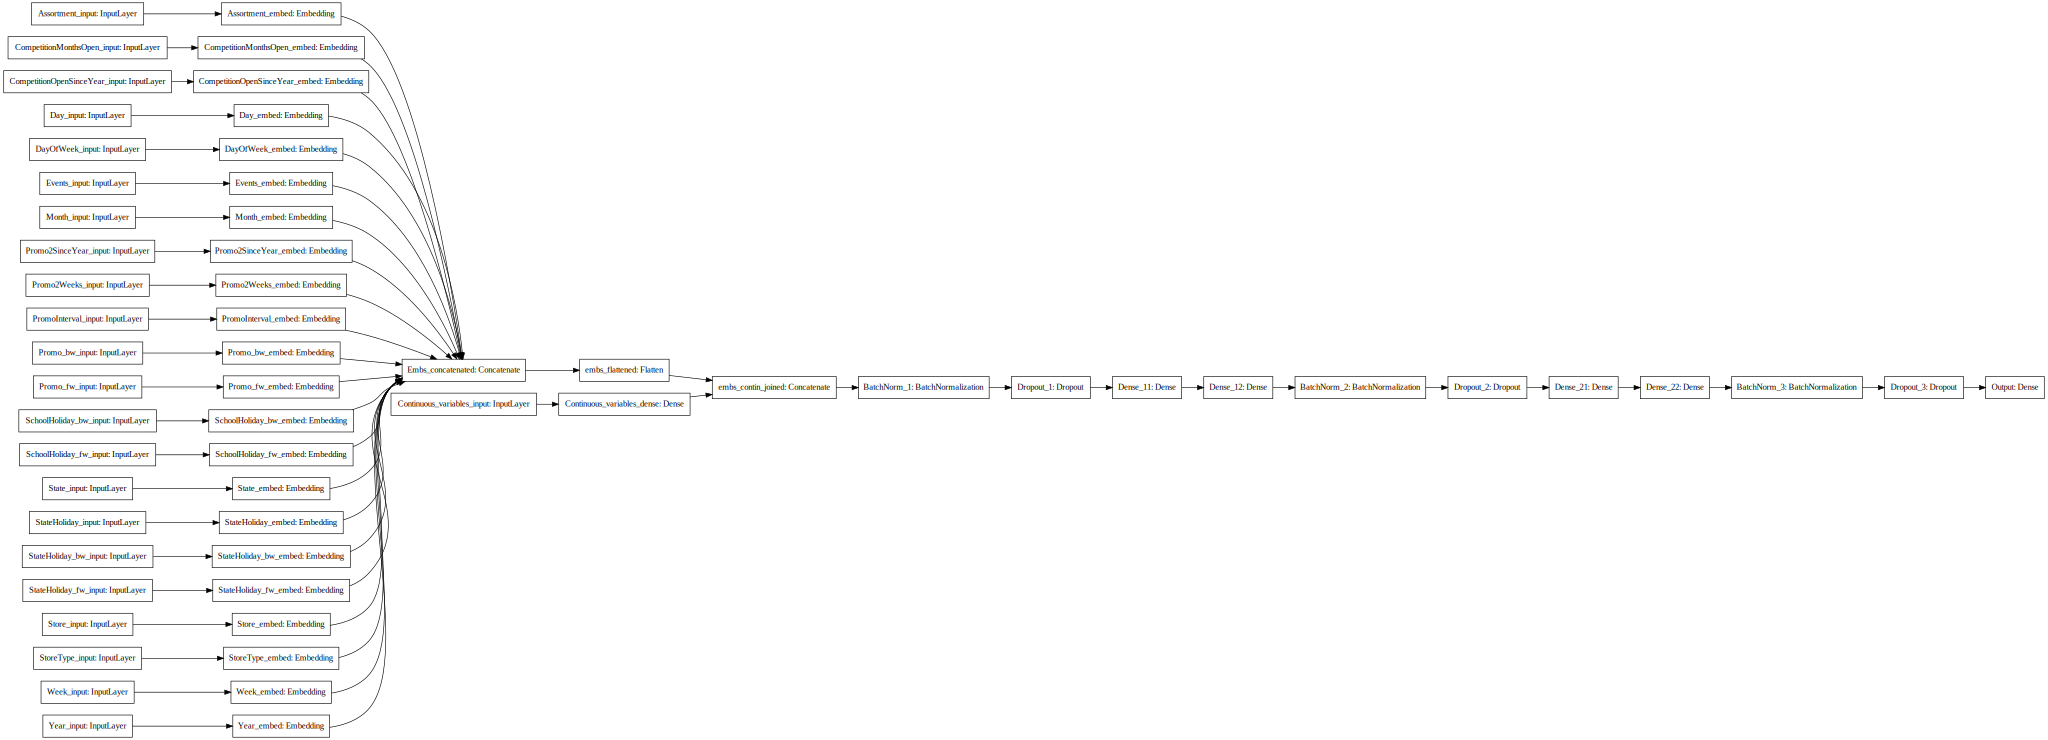

In [33]:
from misc_utils import visualize_model

visualize_model(big_model)

### Training Model

Not loading model Weights from previous model



Epoch 00014: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.



Reloading Best Checkpointed weights
Model Training Loss (Without Dropout)= 0.05390113174125295
Model Validation Loss= 0.08710570932726487


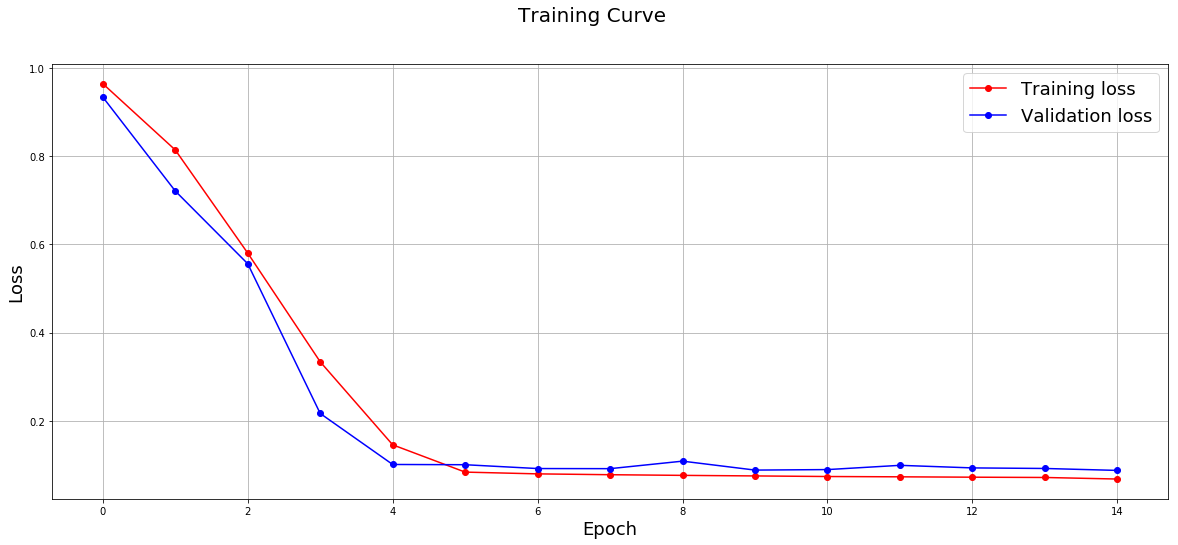

In [34]:
from misc_utils import model_fitter
hist,model=model_fitter(big_model,map_train,y_train,\
                        validation_data=(map_valid,y_valid),checkpoint_path=f"{weights_save_path}saved_model_big",max_epochs=15)

### Generating Predictions

In [35]:
from importlib import reload
import misc_utils
reload(misc_utils)
preds_submit= misc_utils.generate_preds_df(big_model,joined_load_loc=f'{file_save_path}/joined_test.feather',cat_mapper=cat_mapper,contin_mapper=contin_mapper,output_col="Sales")
preds_submit.head()

,Id,Sales
0,1,4427.599121
1,2,7168.367188
2,3,9474.040039
3,4,6978.404785
4,5,7685.152344


### Plotting Predictions on Train and Validation data

In [36]:
from misc_utils import get_train_and_valid_results
save_train,save_valid= get_train_and_valid_results(big_model,train_input=map_train,valid_input=map_valid,\
                                                   train_df=train_df,valid_df=valid_df,\
                                                   return_col_list=["Store","State","DayOfWeek","Sales","Customers","Open","Promo","StateHoliday","SchoolHoliday"],\
                                                   prediction_col_name="PredictedSales")


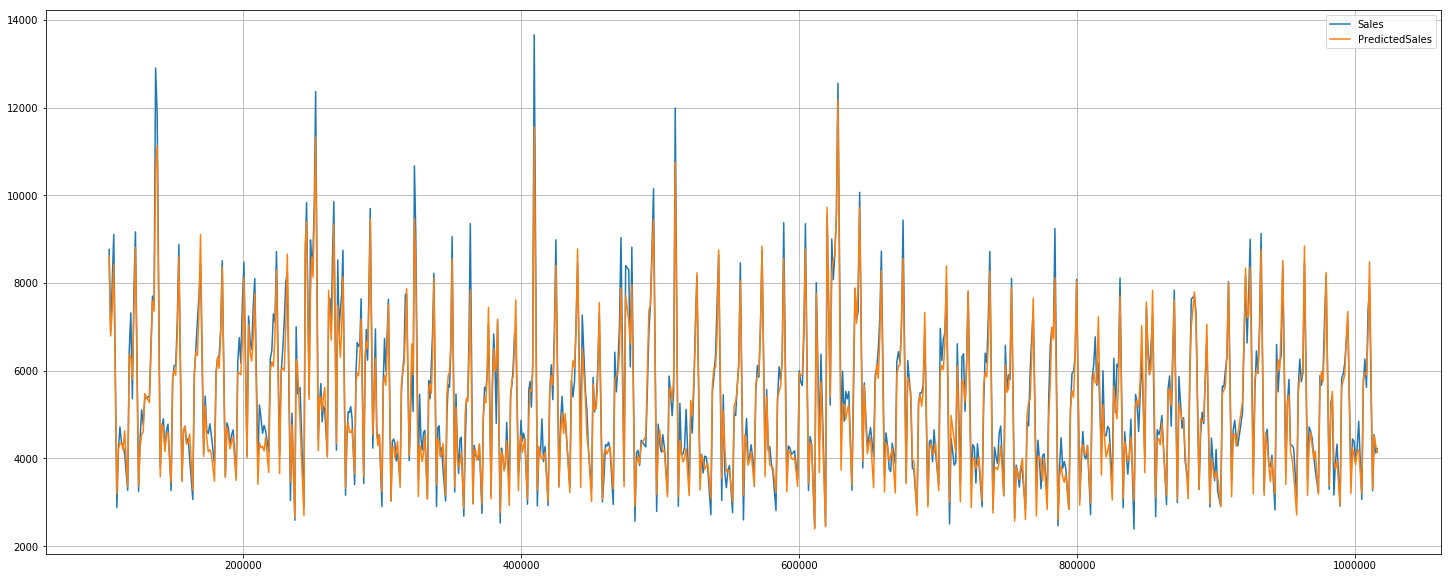

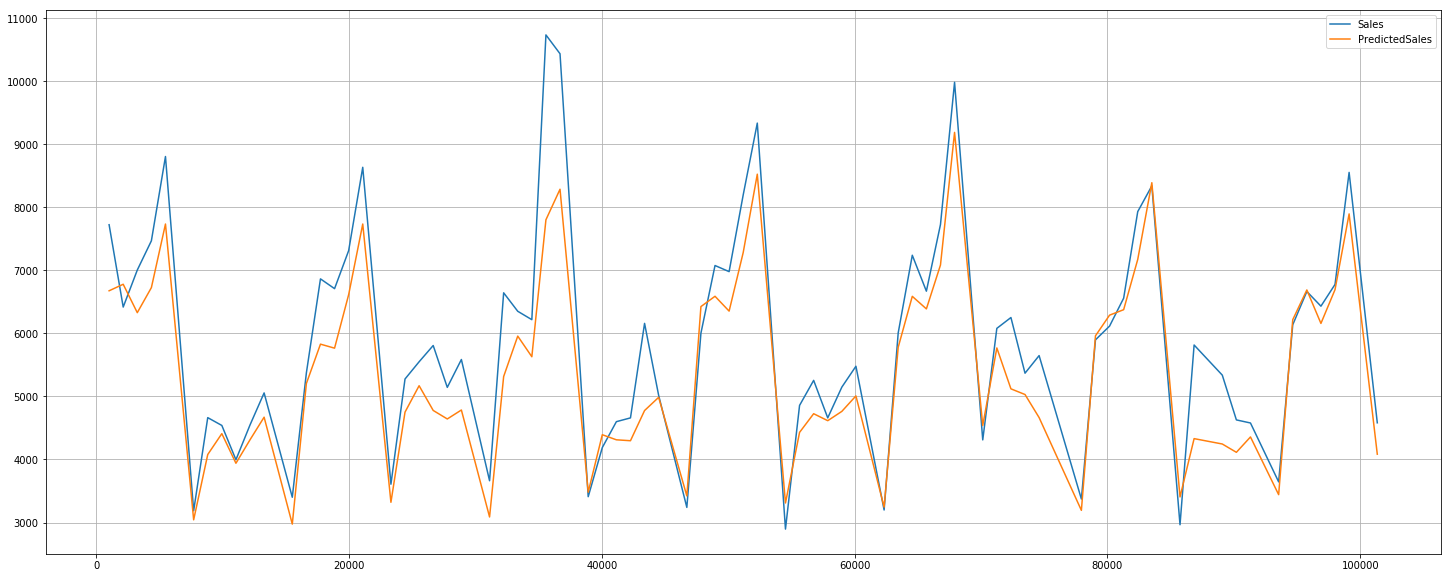

In [37]:
reload(misc_utils)
misc_utils.plot_results("Store",1001,train_df=save_train, valid_df=save_valid,label_col="Sales",prediction_col="PredictedSales")

### Displaying embeddings in Tensorboard

In [43]:
reload(misc_utils)
misc_utils.create_tboard_logs(big_model,cat_mapper)